In [39]:
import os
import pickle
import scipy 
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.signal import get_window
import python_speech_features as mfcc
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import MiniBatchDictionaryLearning

## Feartures Extraction

##### MFCC Feature

In [41]:
def calculate_delta(array):

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first =0
            else:
                first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(file_path):
    audio , sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfcc_feature = mfcc.mfcc(audio,sample_rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [42]:
featuresMagdy = []
directory = './files/magdy/'
for audio in os.listdir('./files/magdy/'):
    audio_path = directory + audio
    featuresMagdy=np.vstack(extract_features(audio_path) )

featuresMayar = []
directory = './files/mayar/'
for audio in os.listdir('./files/mayar/'):
    audio_path = directory + audio
    featuresMayar=np.vstack(extract_features(audio_path) )

featuresMina = []
directory = './files/Mina/'
for audio in os.listdir('./files/Mina/'):
    audio_path = directory + audio
    featuresMina=np.vstack(extract_features(audio_path) )

featuresMostafa = []
directory = './files/mostafa/'
for audio in os.listdir('./files/mostafa/'):
    audio_path = directory + audio
    featuresmostafa=np.vstack(extract_features(audio_path) )

othersFeatures = []
directory = './files/others/'
for audio in os.listdir('./files/others/'):
    audio_path = directory + audio
    othersFeatures=np.vstack(extract_features(audio_path) )

closeFeatures = []
directory = './files/close/'
for audio in os.listdir('./files/close/'):
    audio_path = directory + audio
    closeFeatures=np.vstack(extract_features(audio_path) )

In [43]:
magdy_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
magdy_gmm.fit(featuresMagdy)

mayar_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mayar_gmm.fit(featuresMayar)

mina_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mina_gmm.fit(featuresMina)

mostafa_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
mostafa_gmm.fit(featuresmostafa)

others_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
others_gmm.fit(othersFeatures)

close_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
close_gmm.fit(closeFeatures)

GaussianMixture(covariance_type='diag', max_iter=2000, n_components=6, n_init=3)

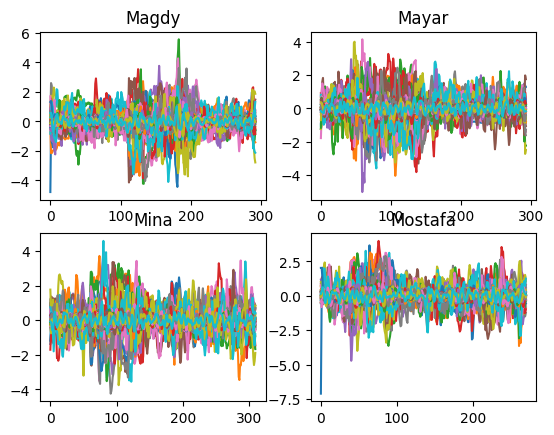

In [44]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(featuresMagdy)
axis[0, 0].set_title("Magdy")

# For Cosine Function
axis[0, 1].plot(featuresMayar)
axis[0, 1].set_title("Mayar")

# For Tangent Function
axis[1, 0].plot(featuresMina)
axis[1, 0].set_title("Mina")

# For Tanh Function
axis[1, 1].plot(featuresmostafa)
axis[1, 1].set_title("Mostafa")

names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

# Combine all the operations and display
plt.show()

In [45]:
pickle.dump(mayar_gmm,open('mayar.gmm','wb'))
pickle.dump(mina_gmm,open('mina.gmm','wb'))
pickle.dump(magdy_gmm,open('magdy.gmm','wb'))
pickle.dump(mostafa_gmm,open('mostafa.gmm','wb'))
pickle.dump(others_gmm,open('others.gmm','wb'))
pickle.dump(close_gmm,open('close.gmm','wb'))

In [50]:
test = extract_features('./files/test/nada_as_tamer.wav')
print(test.size)

11920


In [51]:
scores_1=np.array(others_gmm.score(test))
scores_2=np.array(magdy_gmm.score(test))
scores_3=np.array(mayar_gmm.score(test))
scores_4=np.array(mina_gmm.score(test))
scores_5=np.array(mostafa_gmm.score(test))
scores_6=np.array(close_gmm.score(test))

print(scores_1)
print(scores_2)
print(scores_3)
print(scores_4)
print(scores_5)
print(scores_6)

-31.133266466410088
-27.492414959665016
-26.464298635838556
-28.111426585340933
-29.73632097926634
-32.118049927796704
